In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import json
import sys

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    RepeatedKFold,
    train_test_split,
    ParameterGrid,
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet



from permetrics.regression import RegressionMetric

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
proj_dir = Path('../../..')
seed = 1993

# specify the project directory and file paths
geopackage_fn = (
    proj_dir / "data/gis/geopackages/columbia_river_basin.gpkg"
)  

In [3]:
ml_input_data = pd.read_csv(proj_dir / 'methods/04-ml_development/input_data/ml_input_data.csv')
ann1_test_set = pd.read_csv('ANN1_test_set.csv').rename(columns={'block2_pred': 'ann1_y_pred'})
lr1_test_set = pd.read_csv('LR1_test_set.csv').rename(columns={'y_pred': 'lr1_y_pred'})
rfr1_test_set = pd.read_csv('RFR1_test_set.csv').rename(columns={'y_pred': 'rfr1_y_pred'})

In [4]:
test_set = ml_input_data.merge(lr1_test_set[['Date', 'avg_temp(C)', 'Name', 'lr1_y_pred']], on=['Date', 'avg_temp(C)', 'Name', ], how='outer')
test_set = test_set.merge(rfr1_test_set[['Date', 'avg_temp(C)', 'Name', 'rfr1_y_pred']], on=['Date', 'avg_temp(C)', 'Name', ], how='outer')
test_set = test_set.merge(ann1_test_set[['Date', 'avg_temp(C)', 'Name', 'ann1_y_pred']], on=['Date', 'avg_temp(C)', 'Name', ], how='outer')

lsat_v_insitu = test_set.dropna(subset=['avg_temp(C)', 'WaterTempC'])

In [5]:
lsat_evaluator = RegressionMetric(lsat_v_insitu['avg_temp(C)'].to_list(), lsat_v_insitu['WaterTempC'].to_list())
ann1_evaluator = RegressionMetric(ann1_test_set['avg_temp(C)'].to_list(), ann1_test_set['ann1_y_pred'].to_list())
lr1_evaluator = RegressionMetric(lr1_test_set['avg_temp(C)'].to_list(), lr1_test_set['lr1_y_pred'].to_list())
rfr1_evaluator = RegressionMetric(rfr1_test_set['avg_temp(C)'].to_list(), rfr1_test_set['rfr1_y_pred'].to_list())

In [6]:
list_metrics = ['MAE', 'MSE', 'RMSE', 'R2', 'NSE', 'KGE']

lsat_metrics = lsat_evaluator.get_metrics_by_list_names(list_metrics)
ann1_metrics = ann1_evaluator.get_metrics_by_list_names(list_metrics)
lr1_metrics = lr1_evaluator.get_metrics_by_list_names(list_metrics)
rfr1_metrics = rfr1_evaluator.get_metrics_by_list_names(list_metrics)

In [7]:
test_set.columns

Index(['Date', 'outflow(m3/d)', 'inflow(m3/d)', 'spill(m3/d)', 'avg_temp(C)',
       'wse(m)', 'station_ID', 'RKm', 'Name', 'wse_tail(m)', 'max_temp(C)',
       'min_temp(C)', 'avg discharge (cfs)', 'ReachID', 'LandTempC',
       'WaterTempC', 'NDVI', 'Mission', 'ClimateClass', 'WidthMin',
       'WidthMean', 'WidthMax', 'DOY', 'DOY_scaled', 'WaterTempC_scaled',
       'LandTempC_scaled', 'WidthMax_scaled', 'WidthMean_scaled',
       'WidthMin_scaled', 'NDVI_scaled', 'ClimateClass_scaled',
       'avg_temp(C)_scaled', 'lr1_y_pred', 'rfr1_y_pred', 'ann1_y_pred'],
      dtype='object')

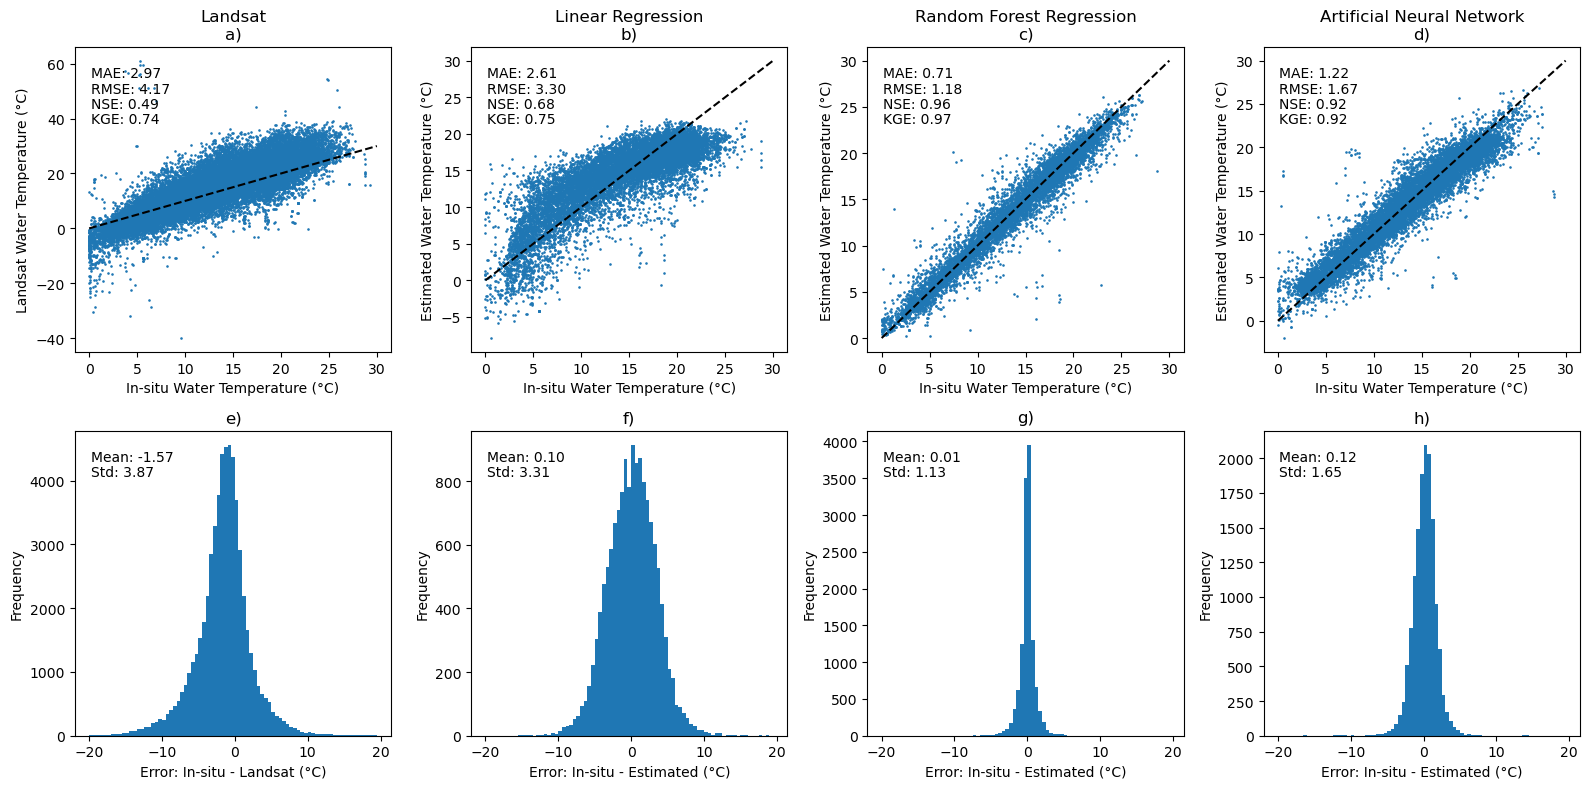

In [8]:
# scatter plot of the test results
fig, ([ax0, ax1, ax2, ax3], [ax4, ax5, ax6, ax7]) = plt.subplots(2, 4, figsize=(16, 8))
test_set.plot.scatter(x="avg_temp(C)", y="WaterTempC", ax=ax0, s=0.75)
test_set.plot.scatter(x="avg_temp(C)", y="lr1_y_pred", ax=ax1, s=0.75)
test_set.plot.scatter(x="avg_temp(C)", y="rfr1_y_pred", ax=ax2, s=0.75)
test_set.plot.scatter(x="avg_temp(C)", y="ann1_y_pred", ax=ax3, s=0.75)


ax0.plot([0, 30], [0, 30], color="k", linestyle="--")
ax1.plot([0, 30], [0, 30], color="k", linestyle="--")
ax2.plot([0, 30], [0, 30], color="k", linestyle="--")
ax3.plot([0, 30], [0, 30], color="k", linestyle="--")

ax0.set_xlabel("In-situ Water Temperature (°C)")
ax1.set_xlabel("In-situ Water Temperature (°C)")
ax2.set_xlabel("In-situ Water Temperature (°C)")
ax3.set_xlabel("In-situ Water Temperature (°C)")


ax0.set_ylabel("Landsat Water Temperature (°C)")
ax1.set_ylabel("Estimated Water Temperature (°C)")
ax2.set_ylabel("Estimated Water Temperature (°C)")
ax3.set_ylabel("Estimated Water Temperature (°C)")

ax0.set_title("Landsat\na)")
ax1.set_title("Linear Regression\nb)")
ax2.set_title("Random Forest Regression\nc)")
ax3.set_title("Artificial Neural Network\nd)")


ax0.annotate(
    f'MAE: {lsat_metrics["MAE"]:.2f}', xy=(0.05, 0.9), xycoords="axes fraction"
)
ax0.annotate(
    f'RMSE: {lsat_metrics["RMSE"]:.2f}', xy=(0.05, 0.85), xycoords="axes fraction"
)
ax0.annotate(
    f'NSE: {lsat_metrics["NSE"]:.2f}', xy=(0.05, 0.8), xycoords="axes fraction"
)
ax0.annotate(
    f'KGE: {lsat_metrics["KGE"]:.2f}', xy=(0.05, 0.75), xycoords="axes fraction"
)
# ax0.annotate(
#     f'R2: {lsat_metrics["R2"]:.2f}', xy=(0.05, 0.7), xycoords="axes fraction"
# )
# ax0.annotate(
#     f'MSE: {lsat_metrics["MSE"]:.2f}', xy=(0.05, 0.65), xycoords="axes fraction"
# )

ax1.annotate(
    f'MAE: {lr1_metrics["MAE"]:.2f}', xy=(0.05, 0.9), xycoords="axes fraction"
)
ax1.annotate(
    f'RMSE: {lr1_metrics["RMSE"]:.2f}', xy=(0.05, 0.85), xycoords="axes fraction"
)
ax1.annotate(
    f'NSE: {lr1_metrics["NSE"]:.2f}', xy=(0.05, 0.8), xycoords="axes fraction"
)
ax1.annotate(
    f'KGE: {lr1_metrics["KGE"]:.2f}', xy=(0.05, 0.75), xycoords="axes fraction"
)
# ax1.annotate(
#     f'R2: {lr1_metrics["R2"]:.2f}', xy=(0.05, 0.7), xycoords="axes fraction"
# )
# ax1.annotate(
#     f'MSE: {lr1_metrics["MSE"]:.2f}', xy=(0.05, 0.65), xycoords="axes fraction"
# )

ax2.annotate(
    f'MAE: {rfr1_metrics["MAE"]:.2f}', xy=(0.05, 0.9), xycoords="axes fraction"
)
ax2.annotate(
    f'RMSE: {rfr1_metrics["RMSE"]:.2f}', xy=(0.05, 0.85), xycoords="axes fraction"
)
ax2.annotate(
    f'NSE: {rfr1_metrics["NSE"]:.2f}', xy=(0.05, 0.8), xycoords="axes fraction"
)
ax2.annotate(
    f'KGE: {rfr1_metrics["KGE"]:.2f}', xy=(0.05, 0.75), xycoords="axes fraction"
)
# ax2.annotate(
#     f'R2: {rfr1_metrics["R2"]:.2f}', xy=(0.05, 0.7), xycoords="axes fraction"
# )
# ax2.annotate(
#     f'MSE: {rfr1_metrics["MSE"]:.2f}', xy=(0.05, 0.65), xycoords="axes fraction"
# )

ax3.annotate(
    f'MAE: {ann1_metrics["MAE"]:.2f}', xy=(0.05, 0.9), xycoords="axes fraction"
)
ax3.annotate(
    f'RMSE: {ann1_metrics["RMSE"]:.2f}', xy=(0.05, 0.85), xycoords="axes fraction"
)
ax3.annotate(
    f'NSE: {ann1_metrics["NSE"]:.2f}', xy=(0.05, 0.8), xycoords="axes fraction"
)
ax3.annotate(
    f'KGE: {ann1_metrics["KGE"]:.2f}', xy=(0.05, 0.75), xycoords="axes fraction"
)
# ax3.annotate(
#     f'R2: {ann1_metrics["R2"]:.2f}', xy=(0.05, 0.7), xycoords="axes fraction"
# )
# ax3.annotate(
#     f'MSE: {ann1_metrics["MSE"]:.2f}', xy=(0.05, 0.65), xycoords="axes fraction"
# )

# histogram of the errors
bins = np.arange(-20, 20, 0.5)
ax4.hist(test_set["avg_temp(C)"]-test_set['WaterTempC'], bins=bins);
ax5.hist(test_set["avg_temp(C)"]-test_set['lr1_y_pred'], bins=bins);
ax6.hist(test_set["avg_temp(C)"]-test_set['rfr1_y_pred'], bins=bins);
ax7.hist(test_set["avg_temp(C)"]-test_set['ann1_y_pred'], bins=bins);

# ax4.set_title("Landsat")
# ax5.set_title("Linear Regression")
# ax6.set_title("Random Forest Regression")
# ax7.set_title("Artificial Neural Network")
ax4.set_title("e)")
ax5.set_title("f)")
ax6.set_title("g)")
ax7.set_title("h)")

ax4.set_xlabel("Error: In-situ - Landsat (°C)")
ax5.set_xlabel("Error: In-situ - Estimated (°C)")
ax6.set_xlabel("Error: In-situ - Estimated (°C)")
ax7.set_xlabel("Error: In-situ - Estimated (°C)")

ax4.set_ylabel("Frequency")
ax5.set_ylabel("Frequency")
ax6.set_ylabel("Frequency")
ax7.set_ylabel("Frequency")

# annotate with mean and std
ax4.annotate(
    f'Mean: {np.mean(test_set["avg_temp(C)"]-test_set["WaterTempC"]):.2f}', xy=(0.05, 0.9), xycoords="axes fraction"
)
ax4.annotate(
    f'Std: {np.std(test_set["avg_temp(C)"]-test_set["WaterTempC"]):.2f}', xy=(0.05, 0.85), xycoords="axes fraction"
)
ax5.annotate(
    f'Mean: {np.mean(test_set["avg_temp(C)"]-test_set["lr1_y_pred"]):.2f}', xy=(0.05, 0.9), xycoords="axes fraction"
)
ax5.annotate(
    f'Std: {np.std(test_set["avg_temp(C)"]-test_set["lr1_y_pred"]):.2f}', xy=(0.05, 0.85), xycoords="axes fraction"
)
ax6.annotate(
    f'Mean: {np.mean(test_set["avg_temp(C)"]-test_set["rfr1_y_pred"]):.2f}', xy=(0.05, 0.9), xycoords="axes fraction"
)
ax6.annotate(
    f'Std: {np.std(test_set["avg_temp(C)"]-test_set["rfr1_y_pred"]):.2f}', xy=(0.05, 0.85), xycoords="axes fraction"
)
ax7.annotate(
    f'Mean: {np.mean(test_set["avg_temp(C)"]-test_set["ann1_y_pred"]):.2f}', xy=(0.05, 0.9), xycoords="axes fraction"
)
ax7.annotate(
    f'Std: {np.std(test_set["avg_temp(C)"]-test_set["ann1_y_pred"]):.2f}', xy=(0.05, 0.85), xycoords="axes fraction"
)

fig.tight_layout()
plt.savefig('model_comparison.png', dpi=300)

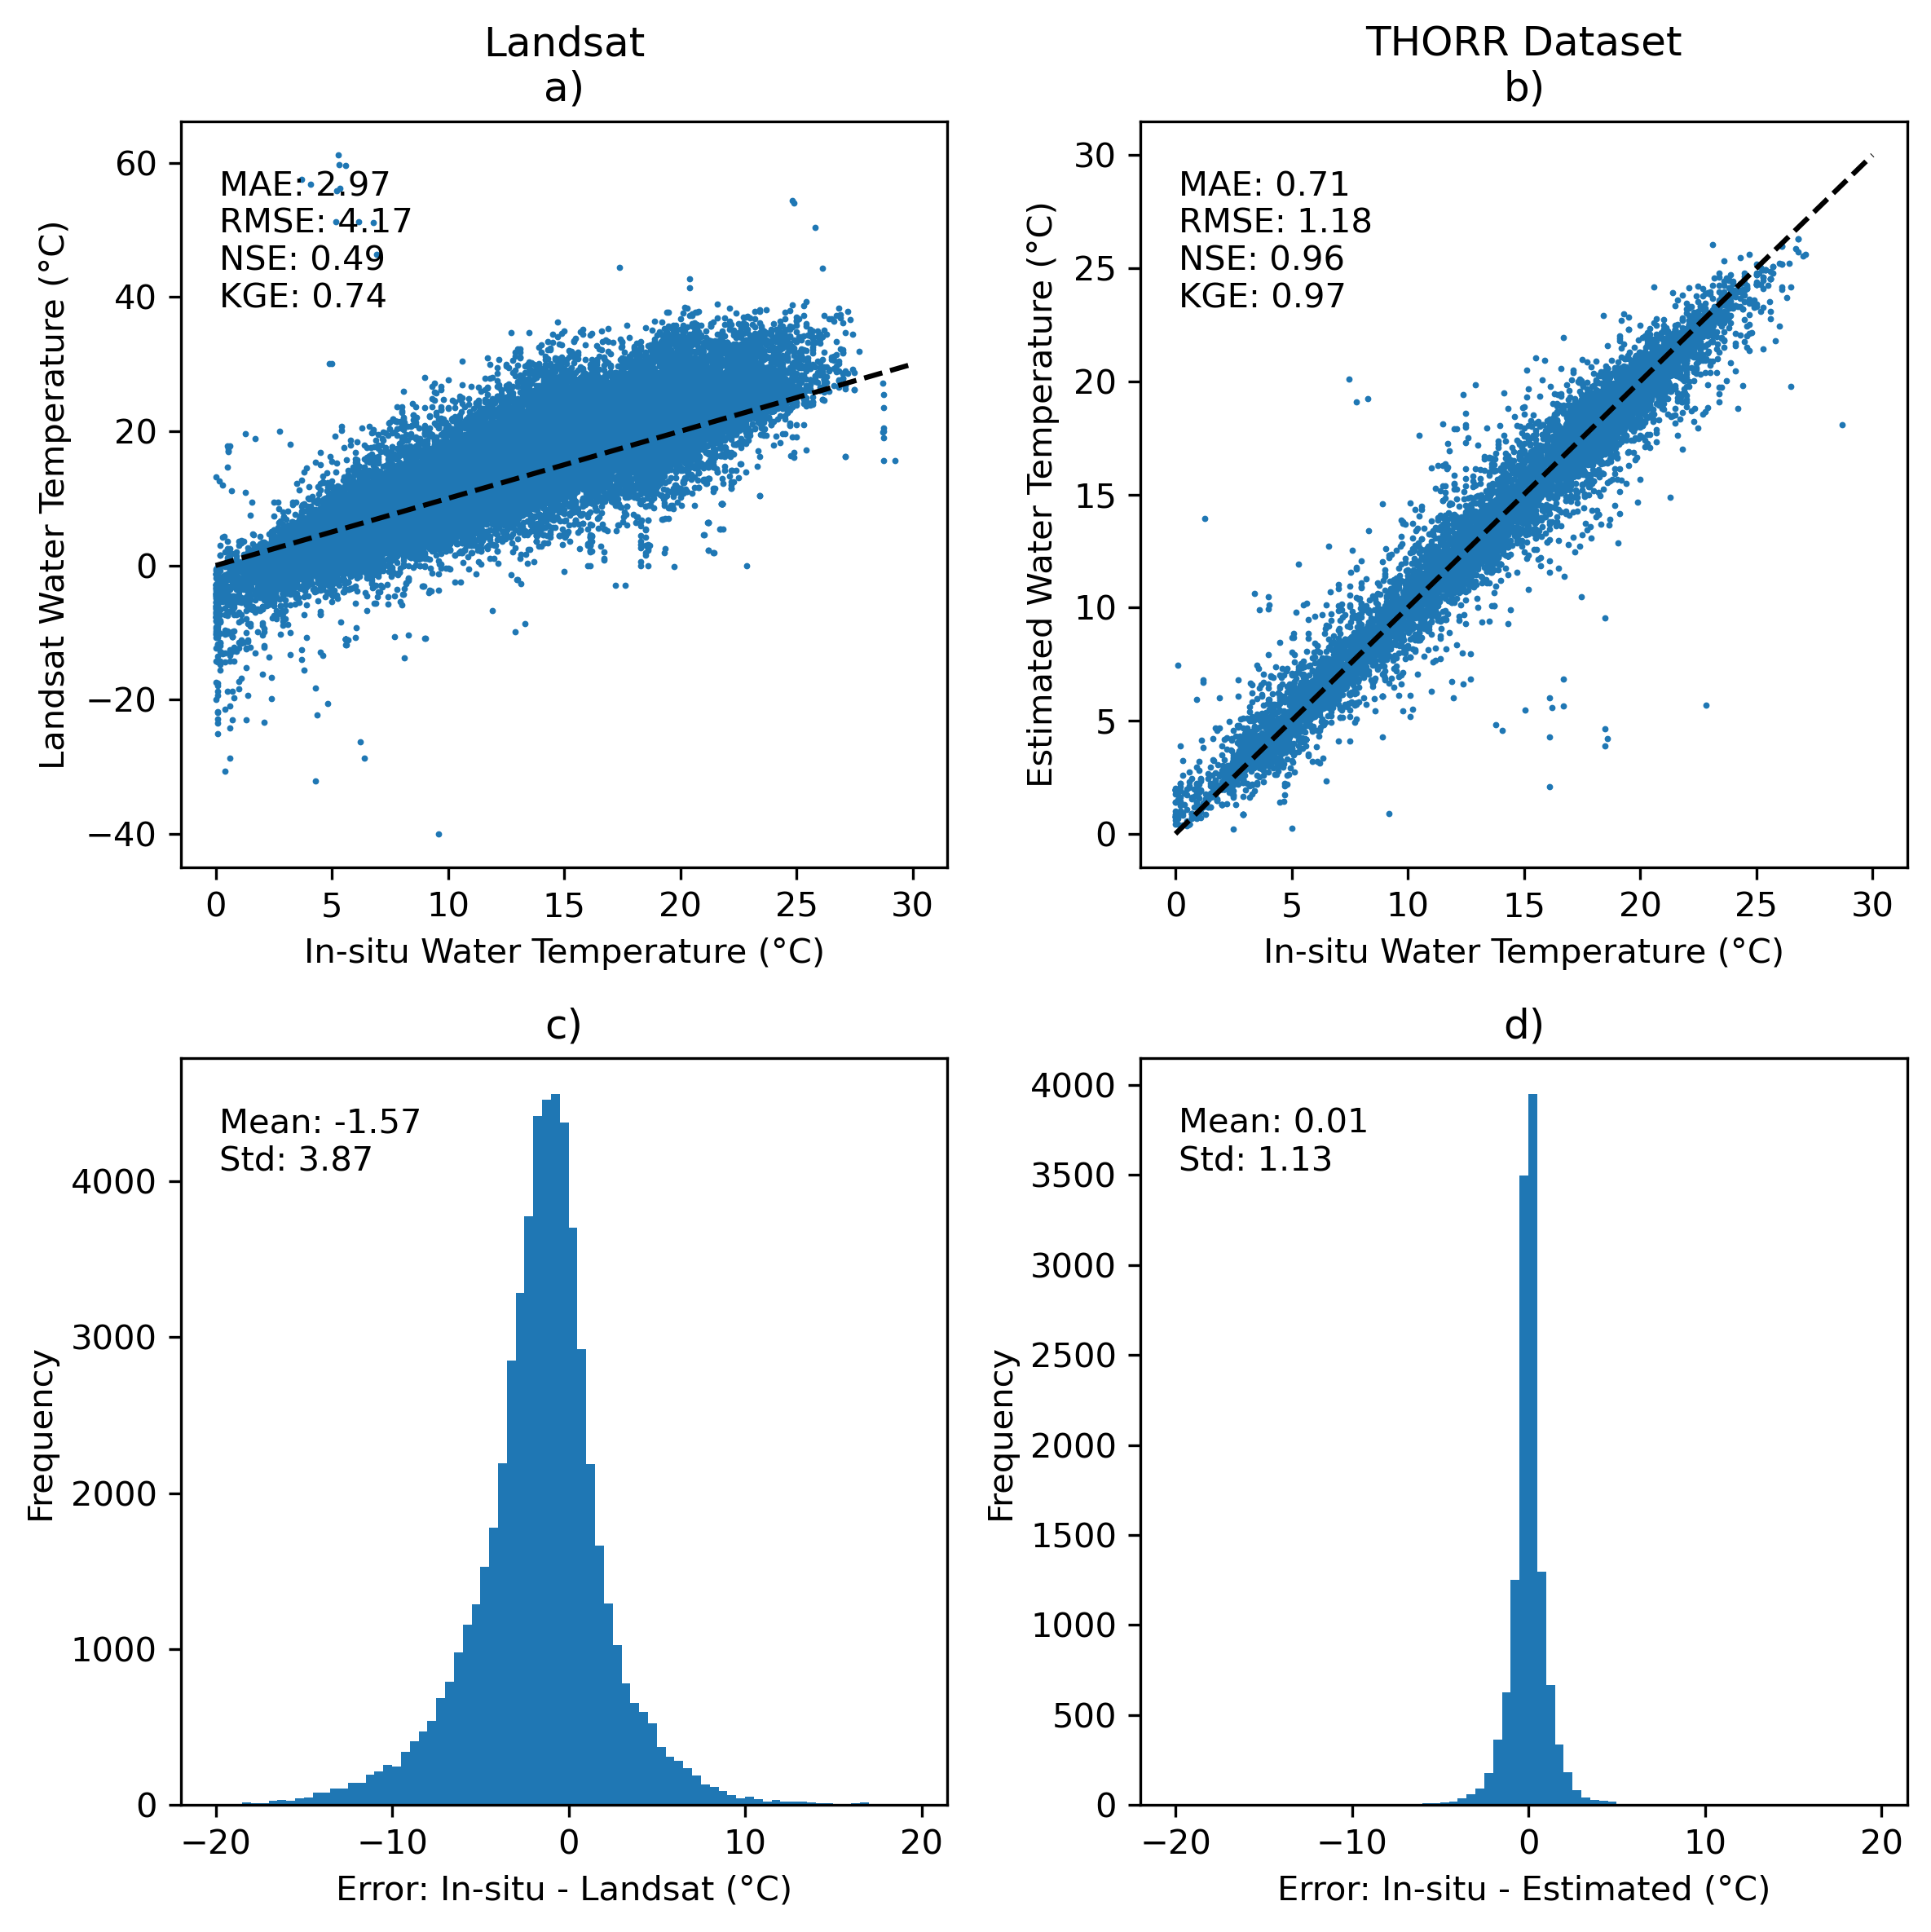

In [18]:
# scatter plot of the test results
fig, ([ax0, ax1], [ax4, ax6]) = plt.subplots(2, 2, figsize=(8, 8), dpi=300)
test_set.plot.scatter(x="avg_temp(C)", y="WaterTempC", ax=ax0, s=0.75)
# test_set.plot.scatter(x="avg_temp(C)", y="lr1_y_pred", ax=ax1, s=0.75)
test_set.plot.scatter(x="avg_temp(C)", y="rfr1_y_pred", ax=ax1, s=0.75)
# test_set.plot.scatter(x="avg_temp(C)", y="ann1_y_pred", ax=ax3, s=0.75)


ax0.plot([0, 30], [0, 30], color="k", linestyle="--")
ax1.plot([0, 30], [0, 30], color="k", linestyle="--")
# ax2.plot([0, 30], [0, 30], color="k", linestyle="--")
# ax3.plot([0, 30], [0, 30], color="k", linestyle="--")

ax0.set_xlabel("In-situ Water Temperature (°C)")
ax1.set_xlabel("In-situ Water Temperature (°C)")
# ax2.set_xlabel("In-situ Water Temperature (°C)")
# ax3.set_xlabel("In-situ Water Temperature (°C)")


ax0.set_ylabel("Landsat Water Temperature (°C)")
ax1.set_ylabel("Estimated Water Temperature (°C)")
# ax2.set_ylabel("Estimated Water Temperature (°C)")
# ax3.set_ylabel("Estimated Water Temperature (°C)")

ax0.set_title("Landsat\na)")
ax1.set_title("THORR Dataset\nb)")
# ax2.set_title("Random Forest Regression\nc)")
# ax3.set_title("Artificial Neural Network\nd)")

# ax0.set_ylim(0, 30)
# ax0.set_xlim(0, 30)


ax0.annotate(
    f'MAE: {lsat_metrics["MAE"]:.2f}', xy=(0.05, 0.9), xycoords="axes fraction"
)
ax0.annotate(
    f'RMSE: {lsat_metrics["RMSE"]:.2f}', xy=(0.05, 0.85), xycoords="axes fraction"
)
ax0.annotate(
    f'NSE: {lsat_metrics["NSE"]:.2f}', xy=(0.05, 0.8), xycoords="axes fraction"
)
ax0.annotate(
    f'KGE: {lsat_metrics["KGE"]:.2f}', xy=(0.05, 0.75), xycoords="axes fraction"
)
# ax0.annotate(
#     f'R2: {lsat_metrics["R2"]:.2f}', xy=(0.05, 0.7), xycoords="axes fraction"
# )
# ax0.annotate(
#     f'MSE: {lsat_metrics["MSE"]:.2f}', xy=(0.05, 0.65), xycoords="axes fraction"
# )

# ax1.annotate(
#     f'MAE: {lr1_metrics["MAE"]:.2f}', xy=(0.05, 0.9), xycoords="axes fraction"
# )
# ax1.annotate(
#     f'RMSE: {lr1_metrics["RMSE"]:.2f}', xy=(0.05, 0.85), xycoords="axes fraction"
# )
# ax1.annotate(
#     f'NSE: {lr1_metrics["NSE"]:.2f}', xy=(0.05, 0.8), xycoords="axes fraction"
# )
# ax1.annotate(
#     f'KGE: {lr1_metrics["KGE"]:.2f}', xy=(0.05, 0.75), xycoords="axes fraction"
# )
# ax1.annotate(
#     f'R2: {lr1_metrics["R2"]:.2f}', xy=(0.05, 0.7), xycoords="axes fraction"
# )
# ax1.annotate(
#     f'MSE: {lr1_metrics["MSE"]:.2f}', xy=(0.05, 0.65), xycoords="axes fraction"
# )

ax1.annotate(
    f'MAE: {rfr1_metrics["MAE"]:.2f}', xy=(0.05, 0.9), xycoords="axes fraction"
)
ax1.annotate(
    f'RMSE: {rfr1_metrics["RMSE"]:.2f}', xy=(0.05, 0.85), xycoords="axes fraction"
)
ax1.annotate(
    f'NSE: {rfr1_metrics["NSE"]:.2f}', xy=(0.05, 0.8), xycoords="axes fraction"
)
ax1.annotate(
    f'KGE: {rfr1_metrics["KGE"]:.2f}', xy=(0.05, 0.75), xycoords="axes fraction"
)
# ax2.annotate(
#     f'R2: {rfr1_metrics["R2"]:.2f}', xy=(0.05, 0.7), xycoords="axes fraction"
# )
# ax2.annotate(
#     f'MSE: {rfr1_metrics["MSE"]:.2f}', xy=(0.05, 0.65), xycoords="axes fraction"
# )

# ax3.annotate(
#     f'MAE: {ann1_metrics["MAE"]:.2f}', xy=(0.05, 0.9), xycoords="axes fraction"
# )
# ax3.annotate(
#     f'RMSE: {ann1_metrics["RMSE"]:.2f}', xy=(0.05, 0.85), xycoords="axes fraction"
# )
# ax3.annotate(
#     f'NSE: {ann1_metrics["NSE"]:.2f}', xy=(0.05, 0.8), xycoords="axes fraction"
# )
# ax3.annotate(
#     f'KGE: {ann1_metrics["KGE"]:.2f}', xy=(0.05, 0.75), xycoords="axes fraction"
# )
# ax3.annotate(
#     f'R2: {ann1_metrics["R2"]:.2f}', xy=(0.05, 0.7), xycoords="axes fraction"
# )
# ax3.annotate(
#     f'MSE: {ann1_metrics["MSE"]:.2f}', xy=(0.05, 0.65), xycoords="axes fraction"
# )

# histogram of the errors
bins = np.arange(-20, 20, 0.5)
ax4.hist(test_set["avg_temp(C)"]-test_set['WaterTempC'], bins=bins);
# ax5.hist(test_set["avg_temp(C)"]-test_set['lr1_y_pred'], bins=bins);
ax6.hist(test_set["avg_temp(C)"]-test_set['rfr1_y_pred'], bins=bins);
# ax7.hist(test_set["avg_temp(C)"]-test_set['ann1_y_pred'], bins=bins);

# ax4.set_title("Landsat")
# ax5.set_title("Linear Regression")
# ax6.set_title("Random Forest Regression")
# ax7.set_title("Artificial Neural Network")
ax4.set_title("c)")
# ax5.set_title("f)")
ax6.set_title("d)")
# ax7.set_title("h)")

ax4.set_xlabel("Error: In-situ - Landsat (°C)")
# ax5.set_xlabel("Error: In-situ - Estimated (°C)")
ax6.set_xlabel("Error: In-situ - Estimated (°C)")
# ax7.set_xlabel("Error: In-situ - Estimated (°C)")

ax4.set_ylabel("Frequency")
# ax5.set_ylabel("Frequency")
ax6.set_ylabel("Frequency")
# ax7.set_ylabel("Frequency")

# annotate with mean and std
ax4.annotate(
    f'Mean: {np.mean(test_set["avg_temp(C)"]-test_set["WaterTempC"]):.2f}', xy=(0.05, 0.9), xycoords="axes fraction"
)
ax4.annotate(
    f'Std: {np.std(test_set["avg_temp(C)"]-test_set["WaterTempC"]):.2f}', xy=(0.05, 0.85), xycoords="axes fraction"
)
# ax5.annotate(
#     f'Mean: {np.mean(test_set["avg_temp(C)"]-test_set["lr1_y_pred"]):.2f}', xy=(0.05, 0.9), xycoords="axes fraction"
# )
# ax5.annotate(
#     f'Std: {np.std(test_set["avg_temp(C)"]-test_set["lr1_y_pred"]):.2f}', xy=(0.05, 0.85), xycoords="axes fraction"
# )
ax6.annotate(
    f'Mean: {np.mean(test_set["avg_temp(C)"]-test_set["rfr1_y_pred"]):.2f}', xy=(0.05, 0.9), xycoords="axes fraction"
)
ax6.annotate(
    f'Std: {np.std(test_set["avg_temp(C)"]-test_set["rfr1_y_pred"]):.2f}', xy=(0.05, 0.85), xycoords="axes fraction"
)
# ax7.annotate(
#     f'Mean: {np.mean(test_set["avg_temp(C)"]-test_set["ann1_y_pred"]):.2f}', xy=(0.05, 0.9), xycoords="axes fraction"
# )
# ax7.annotate(
#     f'Std: {np.std(test_set["avg_temp(C)"]-test_set["ann1_y_pred"]):.2f}', xy=(0.05, 0.85), xycoords="axes fraction"
# )

fig.tight_layout()
# plt.savefig('model_comparison.png', dpi=300)

In [9]:
basins = gpd.read_file(geopackage_fn, layer="Basins") # read the layer "Basins" from the geopackage
rivers = gpd.read_file(geopackage_fn, layer="Rivers") # read the layer "Rivers" from the geopackage
reaches = gpd.read_file(geopackage_fn, layer="Reaches") # read the layer "Reaches" from the geopackage

In [10]:
reaches.rename(columns={'reach_id': 'Name'}, inplace=True)

In [11]:
# merge the test set with the reaches
test_set = test_set.merge(reaches[['Name', 'DistToUpDam', 'DistToDownDam']], on='Name', how='left')

In [12]:
corr_df = test_set[['lr1_y_pred', 'rfr1_y_pred', 'ann1_y_pred', 'WaterTempC', 'avg_temp(C)', 'DistToUpDam', 'DistToDownDam', 'LandTempC', 'WidthMean', 'ClimateClass', 'DOY', 'NDVI']].corr()
corr_df.to_csv('correlation.csv')

<Axes: xlabel='rfr1_y_pred', ylabel='NDVI'>

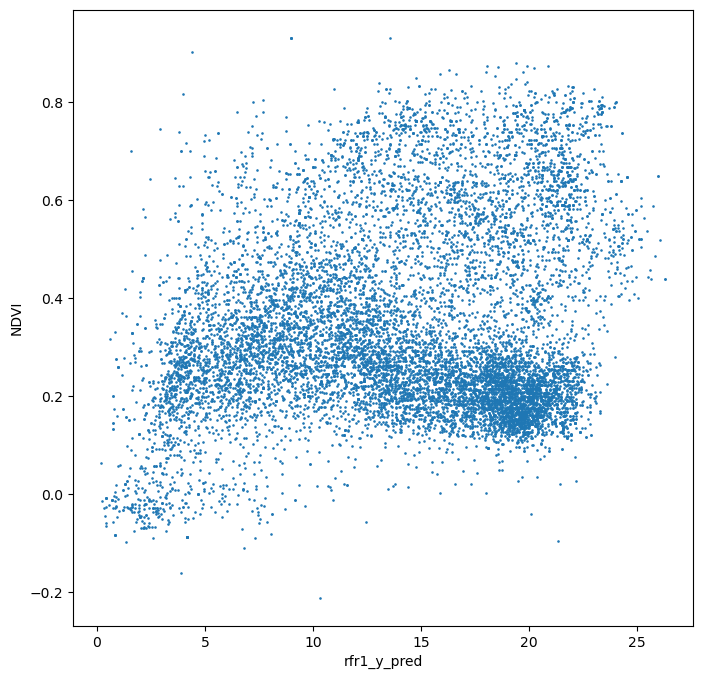

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
test_set.plot.scatter(x="rfr1_y_pred", y="NDVI", ax=ax, s=0.75)

In [14]:
test_set[['rfr1_y_pred', "NDVI"]].dropna()

,rfr1_y_pred,NDVI
12,17.456000,0.510276
13,16.447800,0.408340
14,17.451400,0.534803
24,11.900600,0.377044
31,2.819800,0.005752
...,...,...
59268,24.853000,0.408339
59269,22.724000,0.326296
59278,15.798000,0.345386
59282,14.763000,0.341878


<Axes: xlabel='LandTempC', ylabel='rfr1_y_pred'>

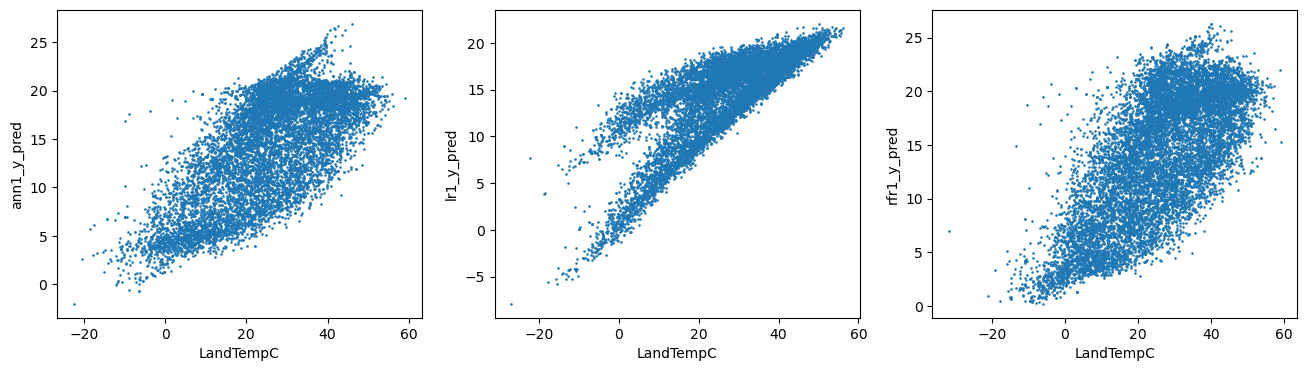

In [15]:
# scatter of predicted vs land temperature 
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
test_set.plot.scatter(x="LandTempC", y="ann1_y_pred", ax=ax[0], s=0.75)
test_set.plot.scatter(x="LandTempC", y="lr1_y_pred", ax=ax[1], s=0.75)
test_set.plot.scatter(x="LandTempC", y="rfr1_y_pred", ax=ax[2], s=0.75)


In [16]:
# count non nan values
test_set['ann1_y_pred'].count(), test_set['lr1_y_pred'].count(), test_set['rfr1_y_pred'].count()

(14447, 14474, 12821)

In [17]:
test_set['avg_temp(C)'].count()

65003

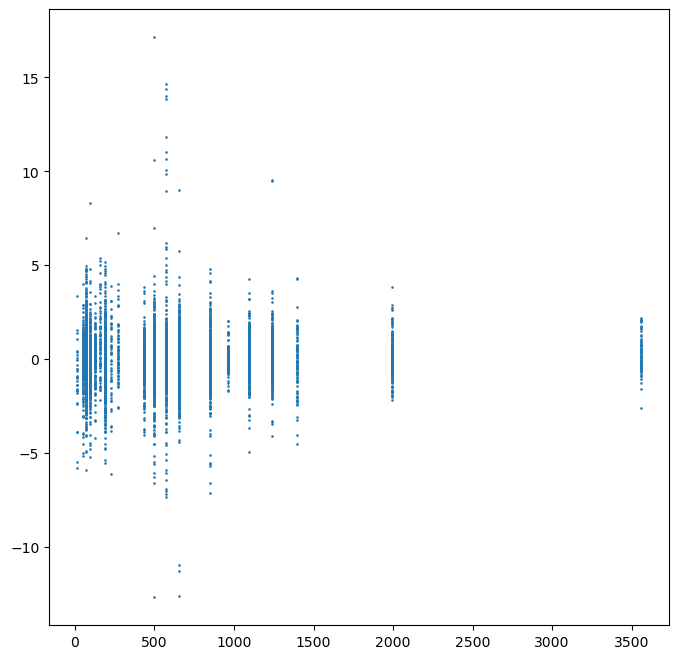

In [18]:
# plot a scatter of the error vs distance to upstream dam
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(test_set['WidthMean'], (test_set["avg_temp(C)"]-test_set['rfr1_y_pred']), s=0.75)

In [19]:
test_set.columns

Index(['Date', 'outflow(m3/d)', 'inflow(m3/d)', 'spill(m3/d)', 'avg_temp(C)',
       'wse(m)', 'station_ID', 'RKm', 'Name', 'wse_tail(m)', 'max_temp(C)',
       'min_temp(C)', 'avg discharge (cfs)', 'ReachID', 'LandTempC',
       'WaterTempC', 'NDVI', 'Mission', 'ClimateClass', 'WidthMin',
       'WidthMean', 'WidthMax', 'DOY', 'DOY_scaled', 'WaterTempC_scaled',
       'LandTempC_scaled', 'WidthMax_scaled', 'WidthMean_scaled',
       'WidthMin_scaled', 'NDVI_scaled', 'ClimateClass_scaled',
       'avg_temp(C)_scaled', 'lr1_y_pred', 'rfr1_y_pred', 'ann1_y_pred',
       'DistToUpDam', 'DistToDownDam'],
      dtype='object')

Text(0, 0.5, 'Absolute error: |In-situ - RFR Estimate| (C)')

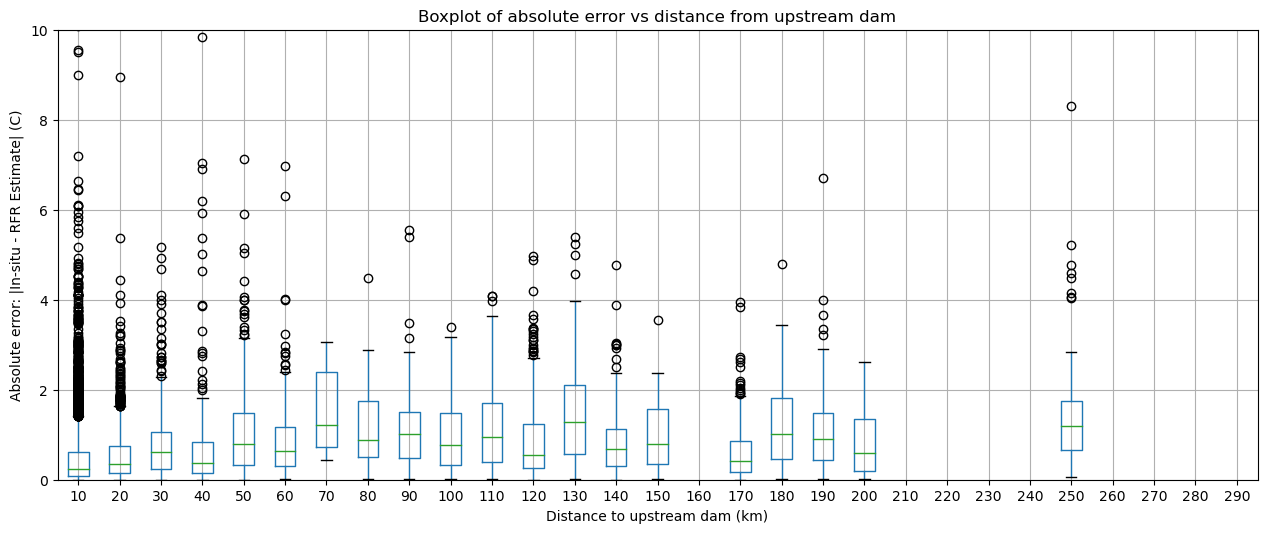

In [20]:
# bin insitu_lsat by average temperature
test_set['DistToUpDam_bin'] = pd.cut(test_set['DistToUpDam'], bins=np.arange(0, 300, 10))
# test_set['DistToUpDam_bin'] = pd.cut(test_set['WidthMean'], bins=np.arange(0, 5000, 120))
test_set['error'] = np.abs(test_set["avg_temp(C)"]-test_set['rfr1_y_pred'])

# find the mid and max of the bins
test_set['DistToUpDam_bin_mid'] = test_set['DistToUpDam_bin'].apply(lambda x: x.mid)
test_set['DistToUpDam_bin_max'] = test_set['DistToUpDam_bin'].apply(lambda x: x.right)

# find the mean and std of the error
mean_error = test_set.groupby('DistToUpDam_bin_max')['error'].mean()
std_error = test_set.groupby('DistToUpDam_bin_max')['error'].std()


fig, ax = plt.subplots(1, 1, figsize=(15, 6))
# box plot of the error vs distance to upstream dam bin
test_set.boxplot(column='error', by='DistToUpDam_bin_max', ax=ax)
# ax.plot(mean_error.index,mean_error.values, color='r')
ax.set_ylim(0, 10)

fig.suptitle('')
ax.set_title('Boxplot of absolute error vs distance from upstream dam')
ax.set_xlabel('Distance to upstream dam (km)')
ax.set_ylabel('Absolute error: |In-situ - RFR Estimate| (C)')

In [23]:
pd.cut(test_set['DistToUpDam'], bins=[0,50,290])

0        (50.0, 290.0]
1        (50.0, 290.0]
2        (50.0, 290.0]
3        (50.0, 290.0]
4        (50.0, 290.0]
             ...      
64998              NaN
64999      (0.0, 50.0]
65000      (0.0, 50.0]
65001      (0.0, 50.0]
65002      (0.0, 50.0]
Name: DistToUpDam, Length: 65003, dtype: category
Categories (2, interval[int64, right]): [(0, 50] < (50, 290]]

Text(0, 0.5, 'Absolute error: |In-situ - RFR Estimate| (C)')

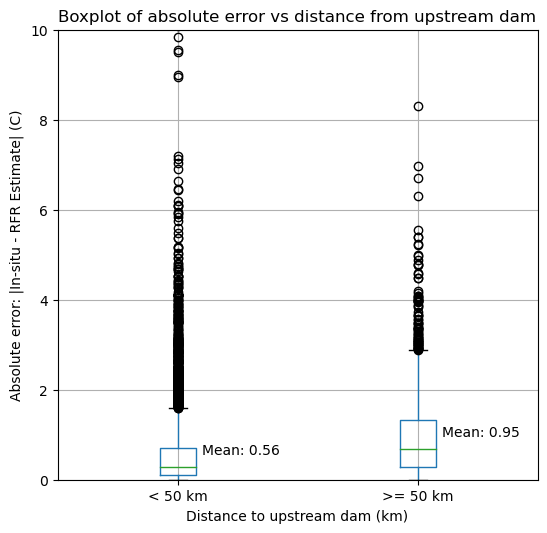

In [61]:
# bin insitu_lsat by average temperature
test_set['DistToUpDam_bin'] = pd.cut(test_set['DistToUpDam'], bins=[0,50,290])
# test_set['DistToUpDam_bin'] = pd.cut(test_set['WidthMean'], bins=np.arange(0, 5000, 120))
test_set['error'] = np.abs(test_set["avg_temp(C)"]-test_set['rfr1_y_pred'])

# find the mid and max of the bins
test_set['DistToUpDam_bin_mid'] = test_set['DistToUpDam_bin'].apply(lambda x: x.mid)
test_set['DistToUpDam_bin_max'] = test_set['DistToUpDam_bin'].apply(lambda x: x.right)

# find the mean and std of the error
mean_error = test_set.groupby('DistToUpDam_bin_max')['error'].mean()
std_error = test_set.groupby('DistToUpDam_bin_max')['error'].std()


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# box plot of the error vs distance to upstream dam bin
test_set.boxplot(column='error', by='DistToUpDam_bin_max', ax=ax)
# ax.plot(mean_error.index,mean_error.values, color='r')

# annotate with mean and std
for i, txt in enumerate(mean_error.index):
    ax.annotate(f'Mean: {mean_error.values[i]:.2f}', (i+1.1, mean_error.values[i]))

ax.set_ylim(0, 10)
ax.set_xticklabels(['< 50 km', '>= 50 km'])

fig.suptitle('')
ax.set_title('Boxplot of absolute error vs distance from upstream dam')
ax.set_xlabel('Distance to upstream dam (km)')
ax.set_ylabel('Absolute error: |In-situ - RFR Estimate| (C)')

<Axes: xlabel='DistToUpDam'>

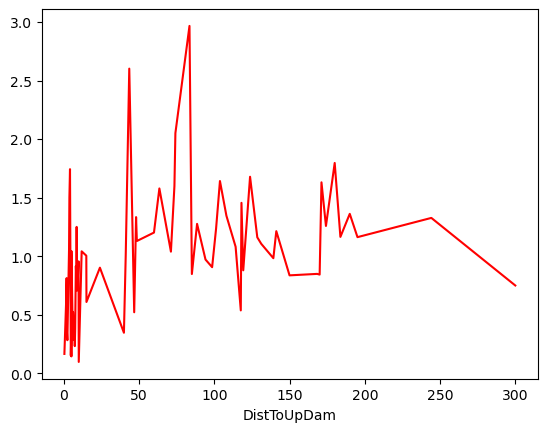

In [16]:
a = test_set.groupby('DistToUpDam')['error']
a.mean().plot(color='r')

Text(0, 0.5, 'Absolute error: |In-situ - RFR Estimate| (C)')

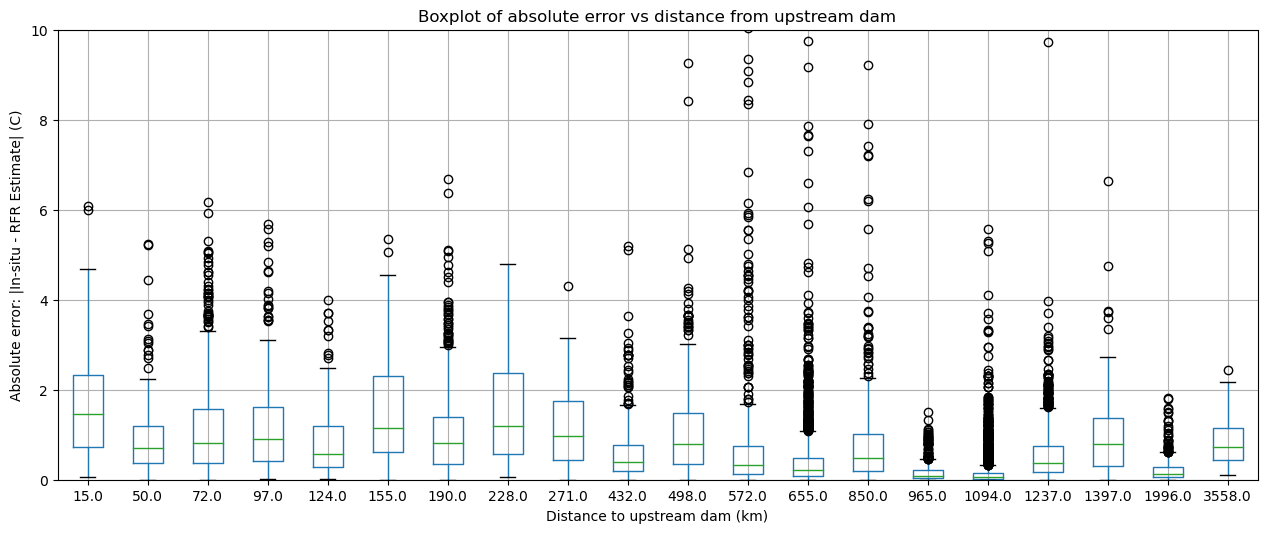

In [17]:
# bin insitu_lsat by average temperature
test_set['DistToUpDam_bin'] = pd.cut(test_set['DistToUpDam'], bins=np.arange(0, 300, 10))
# test_set['DistToUpDam_bin'] = pd.cut(test_set['WidthMean'], bins=np.arange(0, 5000, 120))
test_set['error'] = np.abs(test_set["avg_temp(C)"]-test_set['rfr1_y_pred'])

# find the mid and max of the bins
test_set['DistToUpDam_bin_mid'] = test_set['DistToUpDam_bin'].apply(lambda x: x.mid)
test_set['DistToUpDam_bin_max'] = test_set['DistToUpDam_bin'].apply(lambda x: x.right)

# find the mean and std of the error
mean_error = test_set.groupby('WidthMean')['error'].mean()
std_error = test_set.groupby('WidthMean')['error'].std()


fig, ax = plt.subplots(1, 1, figsize=(15, 6))
# box plot of the error vs distance to upstream dam bin
test_set.boxplot(column='error', by='WidthMean', ax=ax)
# ax.plot(mean_error.index,mean_error.values, color='r')
ax.set_ylim(0, 10)

fig.suptitle('')
ax.set_title('Boxplot of absolute error vs distance from upstream dam')
ax.set_xlabel('Distance to upstream dam (km)')
ax.set_ylabel('Absolute error: |In-situ - RFR Estimate| (C)')

In [18]:
test_set[test_set['WidthMean'] >2000]

,Date,outflow(m3/d),inflow(m3/d),spill(m3/d),avg_temp(C),wse(m),station_ID,RKm,Name,wse_tail(m),...,avg_temp(C)_scaled,lr1_y_pred,rfr1_y_pred,ann1_y_pred,DistToUpDam,DistToDownDam,DistToUpDam_bin,error,DistToUpDam_bin_mid,DistToUpDam_bin_max
19306,2014-04-24,NaN,NaN,NaN,11.2,NaN,USGS_461518123285700,40,Columbia_River_5,NaN,...,-0.507488,NaN,NaN,10.816024,189.970463,NaN,"(180, 190]",NaN,185.0,190
19307,2014-04-25,NaN,NaN,NaN,11.3,NaN,USGS_461518123285700,40,Columbia_River_5,NaN,...,-0.490415,NaN,NaN,NaN,189.970463,NaN,"(180, 190]",NaN,185.0,190
19308,2014-05-11,NaN,NaN,NaN,13.0,NaN,USGS_461518123285700,40,Columbia_River_5,NaN,...,-0.200165,NaN,NaN,11.977988,189.970463,NaN,"(180, 190]",NaN,185.0,190
19309,2014-05-19,NaN,NaN,NaN,14.7,NaN,USGS_461518123285700,40,Columbia_River_5,NaN,...,0.090085,NaN,NaN,NaN,189.970463,NaN,"(180, 190]",NaN,185.0,190
19310,2014-05-27,NaN,NaN,NaN,15.4,NaN,USGS_461518123285700,40,Columbia_River_5,NaN,...,0.209600,NaN,NaN,14.510290,189.970463,NaN,"(180, 190]",NaN,185.0,190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33472,2003-09-01,3.131612e+08,NaN,NaN,21.4,NaN,USGS_14246900,80,Columbia_River_9,NaN,...,1.234011,NaN,NaN,20.788360,149.970465,NaN,"(140, 150]",NaN,145.0,150
33473,2003-09-02,2.740160e+08,NaN,NaN,21.5,NaN,USGS_14246900,80,Columbia_River_9,NaN,...,1.251084,18.791223,NaN,NaN,149.970465,NaN,"(140, 150]",NaN,145.0,150
33474,2003-09-18,2.446572e+08,NaN,NaN,19.1,NaN,USGS_14246900,80,Columbia_River_9,NaN,...,0.841320,NaN,NaN,NaN,149.970465,NaN,"(140, 150]",NaN,145.0,150
33475,2003-09-25,2.666763e+08,NaN,NaN,18.9,NaN,USGS_14246900,80,Columbia_River_9,NaN,...,0.807173,NaN,NaN,NaN,149.970465,NaN,"(140, 150]",NaN,145.0,150


<Axes: xlabel='WidthMean'>

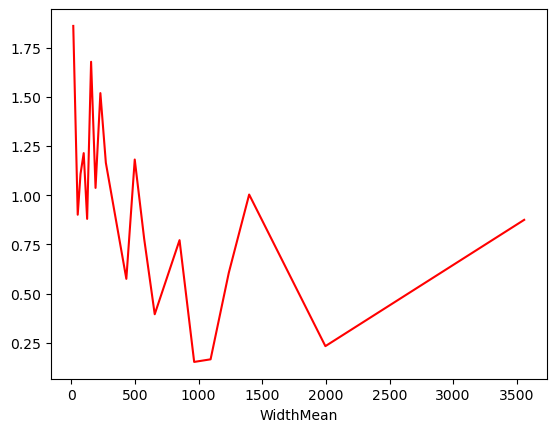

In [27]:
a = test_set.groupby('WidthMean')['error']
a.mean().plot(color='r')

In [30]:
# width_err_agg = test_set.groupby('WidthMean').agg({'error': ['mean', 'std']})['error'].reset_index()
test_set.groupby('WidthMean').agg({'error': ['mean', 'std']})['error'].reset_index()

,WidthMean,mean,std
0,15.0,1.860956,1.657075
1,50.0,0.901235,0.821079
2,72.0,1.108540,0.992318
3,97.0,1.214387,1.123923
4,124.0,0.880152,0.869561
5,155.0,1.678725,1.713018
6,190.0,1.037577,0.939332
7,228.0,1.519440,1.247407
8,271.0,1.165344,0.929275
9,432.0,0.575336,0.610136


In [32]:
# bin insitu_lsat by average temperature
test_set['width_mean_bin'] = pd.cut(test_set['WidthMean'], bins=np.arange(0, 5000, 120))

# calculate mean, min, max, 75, 25, and standard deviation of water temperature
width_err_agg = test_set.groupby('width_mean_bin').agg({'error': ['mean', 'min', 'max', 'std', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), lambda x: x.quantile(0.5), lambda x: np.sqrt(np.mean(x**2)), lambda x: np.abs(x).mean()]})

width_err_agg.columns = ['mean', 'min', 'max', 'std', 'q25', 'q75', 'q50', 'rmse', 'mae']

width_err_agg.reset_index(inplace=True)
width_err_agg['WidthMean'] = width_err_agg['width_mean_bin'].apply(lambda x: x.mid)
# convert mean width to numeric
width_err_agg['WidthMean'] = pd.to_numeric(width_err_agg['WidthMean'])

width_err_agg['iqr'] = width_err_agg['q75'] - width_err_agg['q25']
# width_err_agg.dropna(inplace=True)

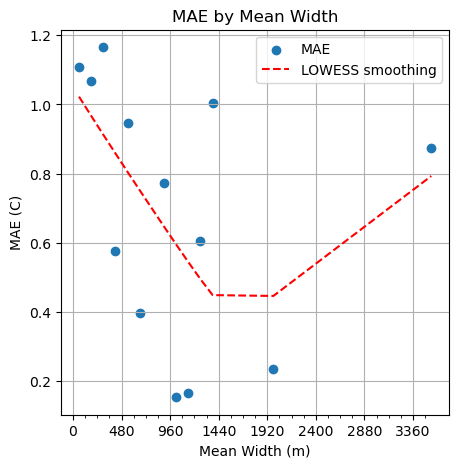

In [35]:
# plot the mean errors
fig, ax = plt.subplots(figsize=(5,5))
# width_err_agg.plot('WidthMean', 'rmse', ax=ax, label='mean', color='black')
# width_err_agg.plot('WidthMean', 'abs_error_mean', ax=ax, label='abs mean', color='red')
# ax.plot(width_err_agg['WidthMean'], width_err_agg['mae'], marker='o')
ax.scatter(width_err_agg['WidthMean'], width_err_agg['mae'], marker='o', label='MAE')
ax.set_ylabel('MAE (C)')
ax.set_xlabel('Mean Width (m)')
ax.set_title('MAE by Mean Width')

# add a lowess smoothing line
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
z = lowess(width_err_agg['mae'], width_err_agg['WidthMean'], frac=1)
ax.plot(z[:, 0], z[:, 1], color='red', linestyle='--', label='LOWESS smoothing')
# add grid
ax.grid()
ax.set_xticks(np.arange(0, 3600, 480))
# set minor ticks
ax.set_xticks(np.arange(0, 3600, 120), minor=True)
ax.legend();


In [56]:

test_set.groupby('DistToUpDam_bin_max').aggregate({'error': ['mean', 'std']})['error'].reset_index()

,DistToUpDam_bin_max,mean,std
0,10,0.366910,0.708602
1,20,0.770018,0.680606
2,30,0.902683,0.777560
3,40,0.347187,0.514321
4,50,0.805654,1.053684
5,60,1.202322,2.067748
6,70,1.578750,1.167879
7,80,1.403114,1.134051
8,90,0.968312,0.898234
9,100,0.964932,0.817355


array([0.36690983, 0.77001794, 0.90268273, 0.34718713, 0.80565351,
       1.20232173, 1.57875   , 1.40311448, 0.96831222, 0.96493217,
       1.3444284 , 0.90190654, 1.62128122, 0.99118114, 1.07433884,
              nan, 0.84886248, 1.47342843, 1.17121729, 1.16331059,
              nan,        nan,        nan,        nan, 1.32748636,
              nan,        nan,        nan,        nan])

In [14]:
# correlation between errors and distance to upstream dam
test_set[['error', 'DistToUpDam']].corr()

,error,DistToUpDam
error,1.000000,0.101475
DistToUpDam,0.101475,1.000000


In [36]:
cutoff = 50

lt50 = test_set[test_set['DistToUpDam'] < cutoff].dropna(subset=['rfr1_y_pred'])
gt50 = test_set[test_set['DistToUpDam'] >= cutoff].dropna(subset=['avg_temp(C)', 'rfr1_y_pred'])

lt50_metrics = RegressionMetric(lt50['avg_temp(C)'].to_list(), lt50['rfr1_y_pred'].to_list()).get_metrics_by_list_names(list_metrics)
gt50_metrics = RegressionMetric(gt50['avg_temp(C)'].to_list(), gt50['rfr1_y_pred'].to_list()).get_metrics_by_list_names(list_metrics)

In [37]:
gt50_metrics

{'MAE': 0.9446978612386812,
 'MSE': 1.8447706736087541,
 'RMSE': 1.3582233518861153,
 'R2': 0.9531143015168061,
 'NSE': 0.9531143015168061,
 'KGE': 0.9622771669565733}

In [38]:
test_set['DistToUpDam'].max()

299.9276038001775

In [39]:
downstream_analysis = pd.DataFrame(columns=['cutoff_dist',] + [metric + '_lt' for metric in list_metrics] + [metric + '_gt' for metric in list_metrics])
# downstream_analysis

for i, cutoff_dist in enumerate(np.arange(10, 300, 10)):

    # print(f'cutoff_dist: {cutoff_dist}')
    test_set_ = test_set.dropna(subset=['DistToUpDam', 'avg_temp(C)', 'rfr1_y_pred'])
    lt = test_set_[test_set_['DistToUpDam'] < cutoff_dist]
    gt = test_set_[test_set_['DistToUpDam'] >= cutoff_dist]

    # print(gt.head())

    # # print(f'cutoff_dist: {cutoff_dist}')
    lt_metrics = RegressionMetric(lt['avg_temp(C)'].to_list(), lt['rfr1_y_pred'].to_list()).get_metrics_by_list_names(list_metrics)
    gt_metrics = RegressionMetric(gt['avg_temp(C)'].to_list(), gt['rfr1_y_pred'].to_list()).get_metrics_by_list_names(list_metrics)

    downstream_analysis.loc[i] = [cutoff_dist]+[lt_metrics[metric] for metric in list_metrics] + [gt_metrics[metric] for metric in list_metrics]



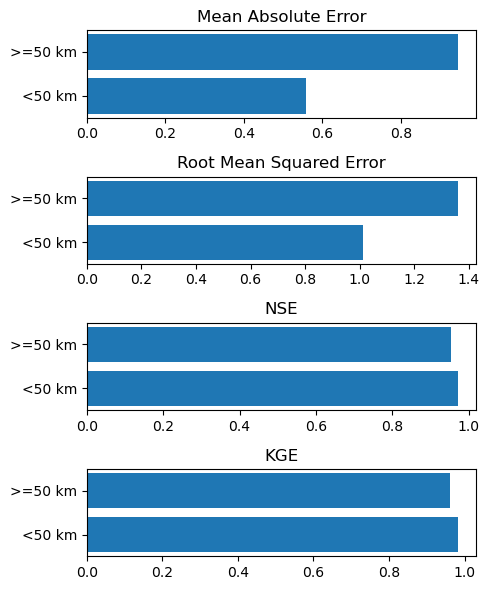

In [56]:
fig, ax = plt.subplots(4, 1, figsize=(5, 6))

downstream_analysis_50 = downstream_analysis[downstream_analysis['cutoff_dist'] == 50]

# bar plot of greater than 50 km vs less than 50 kme; horizontal bar plot
ax[0].barh(['<50 km', '>=50 km'], [lt50_metrics['MAE'], gt50_metrics['MAE']])
ax[1].barh(['<50 km', '>=50 km'], [lt50_metrics['RMSE'], gt50_metrics['RMSE']])
# ax[2].barh(['<50 km', '>=50 km'], [lt50_metrics['R2'], gt50_metrics['R2']])
ax[2].barh(['<50 km', '>=50 km'], [lt50_metrics['NSE'], gt50_metrics['NSE']])
ax[3].barh(['<50 km', '>=50 km'], [lt50_metrics['KGE'], gt50_metrics['KGE']])

ax[0].set_title('Mean Absolute Error')
ax[1].set_title('Root Mean Squared Error')
# ax[2].set_title('R2')
ax[2].set_title('NSE')
ax[3].set_title('KGE')

fig.tight_layout()


In [41]:
lt50_metrics

{'MAE': 0.558291328763505,
 'MSE': 1.0206889550648386,
 'RMSE': 1.0102915198420892,
 'R2': 0.970177642860257,
 'NSE': 0.970177642860257,
 'KGE': 0.981258324696048}

In [42]:
gt50_metrics

{'MAE': 0.9446978612386812,
 'MSE': 1.8447706736087541,
 'RMSE': 1.3582233518861153,
 'R2': 0.9531143015168061,
 'NSE': 0.9531143015168061,
 'KGE': 0.9622771669565733}

In [24]:
list_metrics

['MAE', 'MSE', 'RMSE', 'R2', 'NSE', 'KGE']

Text(0.5, 1.0, 'Mean Absolute Error vs Distance downstream of dam')

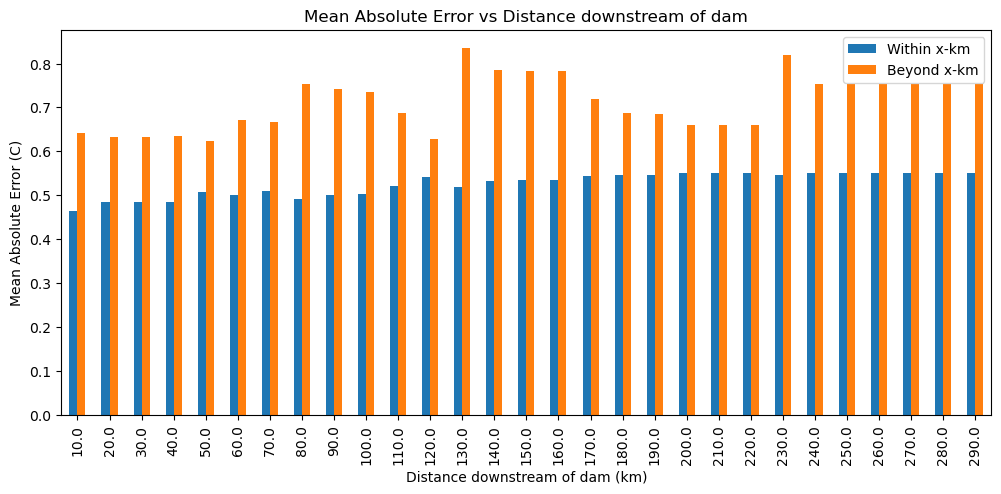

In [69]:
#  for each distance downstream, plot the lt and gt mae as bar plot
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
downstream_analysis.plot.bar(x='cutoff_dist', y=['MAE_lt', 'MAE_gt'], ax=ax, label=['Within x-km', 'Beyond x-km'])
ax.set_xlabel('Distance downstream of dam (km)')
ax.set_ylabel('Mean Absolute Error (C)')
ax.set_title('Mean Absolute Error vs Distance downstream of dam')


In [74]:
downstream_analysis

,cutoff_dist,MAE_lt,MSE_lt,RMSE_lt,R2_lt,NSE_lt,KGE_lt,MAE_gt,MSE_gt,RMSE_gt,R2_gt,NSE_gt,KGE_gt
0,10.0,0.464438,0.954047,0.976753,0.972513,0.972513,0.981968,0.642159,1.274544,1.128957,0.963013,0.963013,0.973364
1,20.0,0.484148,0.963490,0.981575,0.971752,0.971752,0.981910,0.633286,1.285273,1.133699,0.963359,0.963359,0.972968
2,30.0,0.484148,0.963490,0.981575,0.971752,0.971752,0.981910,0.633286,1.285273,1.133699,0.963359,0.963359,0.972968
3,40.0,0.485831,0.966374,0.983043,0.971606,0.971606,0.981946,0.635919,1.291765,1.136558,0.963297,0.963297,0.972714
4,50.0,0.506390,1.014737,1.007342,0.969996,0.969996,0.981166,0.623072,1.259102,1.122097,0.964580,0.964580,0.972790
5,60.0,0.501685,1.035230,1.017462,0.969233,0.969233,0.980971,0.672325,1.300367,1.140336,0.964376,0.964376,0.969650
6,70.0,0.509820,1.050978,1.025172,0.968717,0.968717,0.980840,0.666585,1.284409,1.133318,0.965122,0.965122,0.968539
7,80.0,0.490599,0.997968,0.998984,0.970343,0.970343,0.981776,0.753006,1.483898,1.218154,0.960208,0.960208,0.964352
8,90.0,0.499952,1.007056,1.003522,0.970305,0.970305,0.981122,0.741376,1.488465,1.220027,0.959458,0.959458,0.965015
9,100.0,0.502609,1.013109,1.006533,0.970115,0.970115,0.980783,0.735784,1.474887,1.214449,0.959917,0.959917,0.965956


Text(0.5, 1.0, 'Mean Absolute Error of Reaches Within x-km downstream of dam')

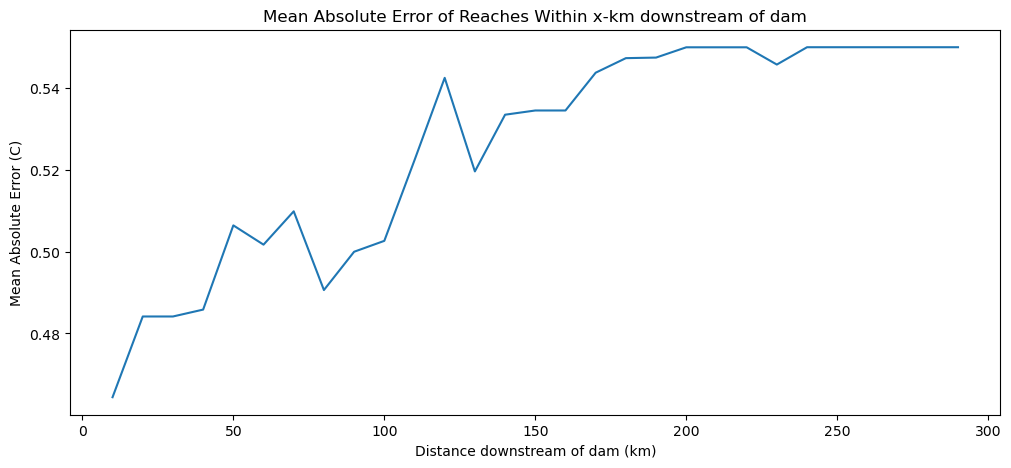

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(downstream_analysis['cutoff_dist'], downstream_analysis['MAE_lt'], label='Within x-km')
ax.set_xlabel('Distance downstream of dam (km)')
ax.set_ylabel('Mean Absolute Error (C)')
ax.set_title('Mean Absolute Error of Reaches Within x-km downstream of dam')


<Axes: xlabel='DistToUpDam_bin'>

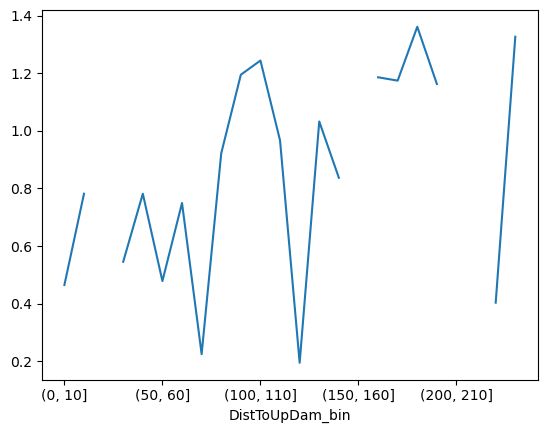

In [47]:
test_set.groupby('DistToUpDam_bin')['error'].mean().plot()

In [20]:
all = test_set.dropna(subset=['avg_temp(C)', 'rfr1_y_pred'])

all_metrics = RegressionMetric(all['avg_temp(C)'].to_list(), all['rfr1_y_pred'].to_list()).get_metrics_by_list_names(list_metrics)

In [21]:
all_metrics

{'MAE': 0.5994794268875838,
 'MSE': 1.2405599535954084,
 'RMSE': 1.1138042707744518,
 'R2': 0.9639568072832445,
 'NSE': 0.9639568072832445,
 'KGE': 0.9744565947164728}

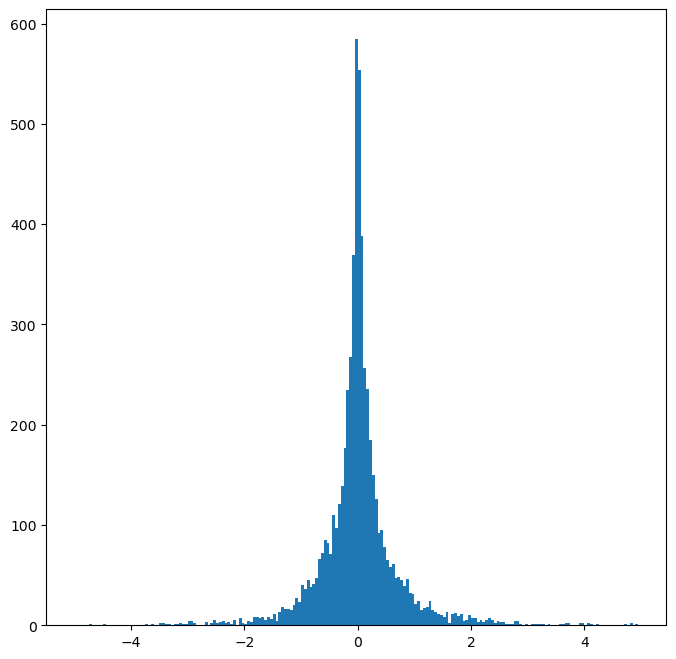

In [31]:
# plot distribution of errors
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.hist(test_set[test_set['DistToUpDam_bin_mid']==5]['error'], bins=np.arange(-5, 5, 0.05));

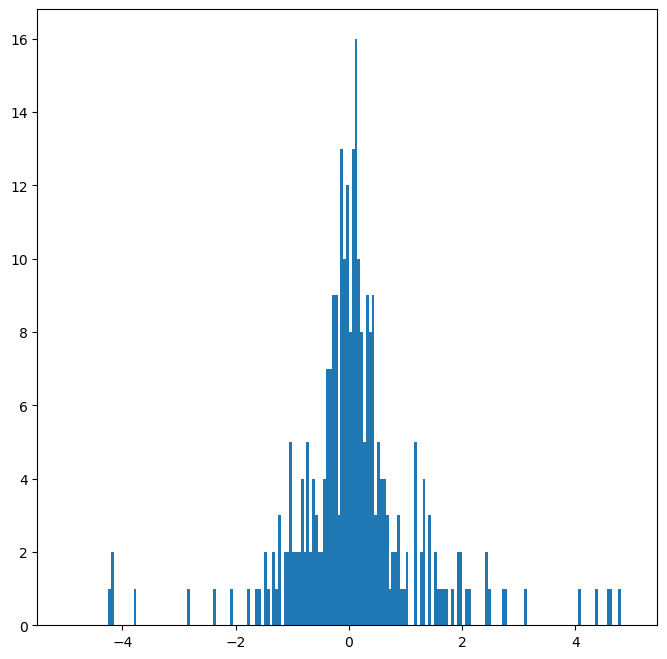

In [37]:
# plot distribution of errors
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.hist(test_set[test_set['DistToUpDam_bin_mid']==65]['error'], bins=np.arange(-5, 5, 0.05));